# Monnet GAN

## Data loading

In [40]:
import cv2
import os
import skimage.transform as st
import numpy as np

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

### Paintings

In [41]:
# Loading of the Monnet paintings
current_working_directory = os.getcwd()
monnet_images_path = current_working_directory + "/monet_jpg"
monnet_images = load_images_from_folder(monnet_images_path)
print("Number of Monnet paintings loaded : {}".format(len(monnet_images)))
print("Shape of a Monnet painting : {}".format(monnet_images[0].shape))
print("Number of elements per painting : {}".format(monnet_images[0].shape[0]*monnet_images[0].shape[1]*monnet_images[0].shape[2]))

monnet_images = np.array(monnet_images)
print(monnet_images[0].shape)
monnet_images = st.resize(monnet_images, (300, 56, 56, 3))
print(monnet_images[0].shape)

input_size = monnet_images[0].shape[0]*monnet_images[0].shape[1]*monnet_images[0].shape[2]

Number of Monnet paintings loaded : 300
Shape of a Monnet painting : (256, 256, 3)
Number of elements per painting : 196608
(256, 256, 3)
(56, 56, 3)


### Photos

In [42]:
# Loading of the Monnet paintings
current_working_directory = os.getcwd()
photo_images_path = current_working_directory + "/photo_jpg"
photo_images = load_images_from_folder(photo_images_path)
print("Number of photos loaded : {}".format(len(photo_images)))
print("Shape of a photo : {}".format(photo_images[0].shape))
print("Number of elements per photo : {}".format(photo_images[0].shape[0]*photo_images[0].shape[1]*photo_images[0].shape[2]))


photo_images = photo_images[:300]

photo_images = np.array(photo_images)

print(photo_images[0].shape)
photo_images = st.resize(photo_images, (300, 56, 56, 3))
print(photo_images[0].shape)

input_size = photo_images[0].shape[0]*photo_images[0].shape[1]*photo_images[0].shape[2]

Number of photos loaded : 7038
Shape of a photo : (256, 256, 3)
Number of elements per photo : 196608
(256, 256, 3)
(56, 56, 3)


### Visualization

(56, 56, 3)


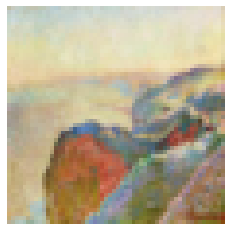

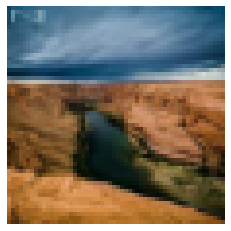

In [43]:
import matplotlib.pyplot as plt 

# Painting display
def display_painting(image):
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    
print(monnet_images[0].shape)
display_painting(monnet_images[0].astype('float32'))
display_painting(photo_images[1].astype('float32'))

## GAN

In [44]:
import torch.nn as nn
import torch
import tensorflow as tf
from torchvision import transforms

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), input_size))
        out = out.view(out.size(0), -1)
        return out

In [45]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, input_size),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), input_size)
        out = self.model(x)
        return out

In [46]:
discriminator = Discriminator()
generator = Generator()

In [47]:
criterion = nn.BCELoss() #BCE standing for Binary Cross Entropy
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [48]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images)
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [49]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [50]:
train_dataset_paintings = torch.from_numpy(monnet_images)
train_loader_paintings = torch.utils.data.DataLoader(train_dataset_paintings, batch_size=50, shuffle=True)
train_iterator_paintings = iter(train_loader_paintings)

train_dataset_photos = torch.from_numpy(photo_images)
train_loader_photos = torch.utils.data.DataLoader(train_dataset_photos, batch_size=50, shuffle=True)
train_iterator_photos = iter(train_loader_photos)

In [51]:
import math
import itertools
import time

# Set number of epochs and initialize figure counter
num_epochs = 50
num_batches = len(train_loader_paintings)

# Set counter
num_fig = 0

# Start timer
t0 = time.time()

# Start training
for epoch in range(num_epochs):  
    for n, (paintings, photos) in enumerate(zip(train_loader_paintings,train_loader_photos)):
        ones = torch.ones(paintings.size(0),1)
        
        fake_paintings = generator.forward(photos.float())
        zeros = torch.zeros(photos.size(0),1)
        
        d_loss, real_score, fake_score = train_discriminator(discriminator, paintings.float(), ones, fake_paintings.float(), zeros)
        
        fake_paintings = generator.forward(photos.float())
        outputs = discriminator.forward(fake_paintings.float())
        g_loss = train_generator(generator, outputs, ones)
        
    print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
              'D(x): %.2f, D(G(z)): %.2f, time %.2f min' 
              %(epoch + 1, num_epochs, n+1, num_batches, d_loss.detach().numpy(), g_loss.detach().numpy(),
                real_score.detach().numpy().mean(), fake_score.detach().numpy().mean(), (time.time()-t0)/60))
        
        
    #display_painting(fake_paintings[0].detach().numpy().reshape(56,56,3).astype('float32'))
    #display_painting(photos[0].detach().numpy().reshape(56,56,3).astype('float32'))
      

Epoch [1/50], Step[6/6], d_loss: 1.6412, g_loss: 1.3094, D(x): 0.81, D(G(z)): 0.75, time 0.12 min
Epoch [2/50], Step[6/6], d_loss: 1.4540, g_loss: 0.5678, D(x): 0.57, D(G(z)): 0.59, time 0.24 min
Epoch [3/50], Step[6/6], d_loss: 0.5489, g_loss: 1.5091, D(x): 0.92, D(G(z)): 0.37, time 0.35 min
Epoch [4/50], Step[6/6], d_loss: 1.0336, g_loss: 2.6366, D(x): 0.86, D(G(z)): 0.57, time 0.47 min
Epoch [5/50], Step[6/6], d_loss: 1.2822, g_loss: 2.3654, D(x): 0.61, D(G(z)): 0.52, time 0.59 min
Epoch [6/50], Step[6/6], d_loss: 1.7572, g_loss: 2.9861, D(x): 0.21, D(G(z)): 0.14, time 0.71 min
Epoch [7/50], Step[6/6], d_loss: 0.1665, g_loss: 7.2404, D(x): 0.86, D(G(z)): 0.01, time 0.83 min
Epoch [8/50], Step[6/6], d_loss: 0.0237, g_loss: 5.6943, D(x): 0.99, D(G(z)): 0.02, time 0.95 min
Epoch [9/50], Step[6/6], d_loss: 0.9237, g_loss: 6.9640, D(x): 0.44, D(G(z)): 0.01, time 1.07 min
Epoch [10/50], Step[6/6], d_loss: 0.0545, g_loss: 8.4816, D(x): 0.95, D(G(z)): 0.01, time 1.18 min
Epoch [11/50], Step


        
        
        
        
        
         # Every half epoch generates pictures with to generator to monitor training
        if (n+1) % int(num_batches/2) == 0:
            # generate pictures
            test_paintings = generator.predict(test_photos)
            
            # plot them
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_photos[k,:].data.cpu().numpy(), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
        
       